<font color='green' size=6>**LightGBM**

LightGBM был разработан инженерами машинного обучения компании Microsoft. Первая версия вышла в апреле 2017.

Особенности LightGBM:
- повершинный способ построения деревьев
- односторонний отбор на основе градиентов (GOSS – Gradient-based One-Side Sampling)
- поиск точек расщепления на основе гистограмм
- связывание взаимоисключающих признаков (EFB – Exclusive Feature Bundling)



## <font color='green' size=5>Повершинный способ построения деревьев

<img src="https://drive.google.com/uc?export=view&id=1zpRWZaWs9YfyGaI1Lm-1Qq8IpNXwa6m2" width="600"/>

С точки зрения построения деревьев LightGBM отличается от XGBoost и CatBoost. Если XGBoost и CatBoost строят деревья слой за слоем, то LightGBM строит деревья лист за листом.

**Уровневый подход (level-wise):** Алгоритм разветвляет все узлы на уровне 1, затем все узлы на уровне 2 и так далее.

- Недостатки:

Менее целенаправленное улучшение: Уровневый подход может разветвлять узлы, которые не вносят значительного вклада в уменьшение функции потерь, что может снижать эффективность.

- Преимущества:

Сбалансированность дерева: Все узлы на одном уровне разветвляются одновременно, что приводит к созданию сбалансированных деревьев.
Простота параллелизации: Так как все узлы на одном уровне разветвляются одновременно, процесс можно легче распараллелить.



**Повершинный подход (leaf-wise):** Алгоритм сначала разветвляет корневой узел, затем выбирает тот узел, который при разветвлении даст наибольшее уменьшение функции потерь, и разветвляет его, независимо от того, на каком он уровне. Это может привести к тому, что одна ветвь дерева будет глубже, чем другие, так как она будет чаще разветвляться.

- Недостатки:

Несбалансированность дерева: Деревья могут быть несбалансированными, с разной глубиной узлов, что может усложнять их интерпретацию.
Сложность параллелизации: Поскольку разветвление происходит выборочно, параллелизация процесса может быть сложнее.

- Преимущества:

Целенаправленное улучшение: Повершинный метод фокусируется на узлах, которые обеспечивают наибольшее уменьшение функции потерь, что делает модель более точной.
Улучшение производительности: Этот подход часто быстрее достигает оптимальных разветвлений, особенно на сложных данных.

В итоге, основное различие между этими подходами заключается в стратегии выбора узлов для разветвления: уровневый метод работает последовательно по уровням, а повершинный метод — по узлам, которые на данный момент дают наибольшее уменьшение функции потерь.


## <font color='green' size=5>Односторонний отбор на основе градиентов (GOSS – Gradient-based One-Side Sampling)

В процессе обучения модели градиенты используются для обновления весов, чтобы минимизировать функцию потерь. Градиенты, по сути, показывают, насколько каждое наблюдение в выборке влияет на функцию потерь.
Большие градиенты (по модулю) указывают на те наблюдения, которые модель пока плохо предсказывает.

**Основные этапы GOSS:**

- GOSS делит все данные на две группы: выборки с большими градиентами и выборки с малыми градиентами.

Из выборок с большими градиентами (например, топ 20% данных) GOSS оставляет все данные, а из выборок с малыми градиентами (оставшиеся 80%) случайным образом отбирается небольшая часть данных (например, 20%).
- Ребалансировка выборки:

Чтобы компенсировать несоразмерность количества данных с малыми градиентами, GOSS увеличивает их веса в обратной пропорции к их количеству. Таким образом, общая информация выборки сохраняется.


### Пример с числами


Представим, что у нас есть 1000 наблюдений, и мы применяем GOSS следующим образом:

- Выбор значимых данных:

Из всех наблюдений выбираем верхние 20% данных с самыми высокими градиентами, то есть  20% от 1000 = 200 выборок

- Выбор случайных менее значимых данных:

Из оставшихся 80% данных  мы случайным образом выбираем 20%, то есть 20% от 800 = 160 наблюдений.
- Корректировка веса:

Чтобы сохранить общую информацию, вес выбранных 160 менее значимых выборок увеличивается в 5 раз (поскольку 800/160 = 5)
- Почему это важно:

  1) Сохранение информации:

Если бы мы просто отбросили все менее значимые данные, модель могла бы потерять важную информацию о распределении данных. Увеличение веса компенсирует это

  2) Балансировка данных:
  
Увеличение веса позволяет сохранить баланс между значимыми и менее значимыми данными, предотвращая перекос модели

3) Улучшение качества модели:

Сохранение пропорционального влияния всех данных позволяет модели лучше обобщаться на новых данных и уменьшает риск переобучения

<font color='green'> **Итоговый результат**

- <font color='green'> Количество выборок:
  
Вместо обучения на всех 1000 выборках, мы обучаем модель на 360 выборках (200 значимых + 160 менее значимых)

- <font color='green'> Корректировка веса:

Вес 160 менее значимых выборок увеличен в 5 раз, чтобы компенсировать уменьшение их количества.


## <font color='green' size=5>Поиск точек расщепления на основе гистограмм

- Создание гистограмм:

  - Для каждого признака (feature) значения разделяются на фиксированное количество бинов (интервалов).
  - Для каждого бина подсчитывается количество выборок, попадающих в этот бин, а также сумма их градиентов и гессианов.

- Обновление гистограмм:

  - Когда происходит разбиение узла, гистограммы для дочерних узлов быстро обновляются, используя данные гистограммы родительского узла. Это значительно уменьшает объем вычислений.
- Поиск оптимальной точки расщепления:

  - Алгоритм проходит по всем бинам гистограммы каждого признака.
  - Для каждого возможного разбиения рассчитывается улучшение (gain) функции потерь.
  - Оптимальной считается точка, которая максимизирует уменьшение функции потерь.

Формула для оценки качества разбиения может выглядеть следующим образом:

$$
\text{Gain} = \frac{(G_{\text{left}})^2}{H_{\text{left}} + \lambda} + \frac{(G_{\text{right}})^2}{H_{\text{right}} + \lambda} - \frac{(G_{\text{total}})^2}{H_{\text{total}} + \lambda}
$$

где:

- $ G_{\text{left}}, G_{\text{right}}, G_{\text{total}} $ — суммы градиентов.
- $ H_{\text{left}}, H_{\text{right}}, H_{\text{total}} $ — суммы гессианов.
- $ \lambda $ — регуляризационный параметр для предотвращения деления на ноль и переобучения.
\end{itemize}


## <font color='green' size=5>Cвязывание взаимоисключающих признаков (EFB – Exclusive Feature Bundling)

Связывание взаимоисключающих признаков (EFB – Exclusive Feature Bundling) — это техника, используемая в LightGBM для уменьшения размера пространства признаков.

- Идентификация взаимоисключающих признаков:

Взаимоисключающие признаки — это такие признаки, которые редко принимают ненулевые значения одновременно. Например, в наборе данных могут быть бинарные признаки, где для каждой выборки только один из группы признаков может быть равен 1, а остальные равны 0.

- Группировка признаков:
Взаимоисключающие признаки группируются вместе. Каждый такой набор признаков кодируется в один комбинированный признак.

Пример

Предположим, у нас есть следующие три бинарных признака:

\begin{align*}
    P_1 &: [0, 1, 0, 0] \\
    P_2 &: [0, 0, 1, 0] \\
    P_3 &: [1, 0, 0, 0]
\end{align*}

Эти признаки взаимоисключают друг друга, так как для каждой выборки только один из них равен 1. Мы можем закодировать их в один признак \( P \) следующим образом:

$$
P = P_1 + 2 \times P_2 + 4 \times P_3
$$

Результирующий признак \( P \) будет выглядеть так:

$$
P: [4, 1, 2, 0]
$$

Теперь вместо трех признаков у нас один закодированный признак, что уменьшает размер пространства признаков и ускоряет процесс обучения.


Техника EFB (Exclusive Feature Bundling) помогает эффективно уменьшать размер пространства признаков, особенно при работе с разреженными данными, ускоряя процесс обучения и снижая потребление памяти. Это достигается за счет группировки взаимоисключающих признаков и их кодирования в комбинированные признаки.


## <font color='green' size=5> Гиперпараметры

https://lightgbm.readthedocs.io/en/stable/Parameters-Tuning.html

Параметр boosting в LightGBM определяет тип базового алгоритма для бустинга. Он задает, как будут строиться и оптимизироваться модели. В LightGBM доступны несколько типов бустинга:

- gbdt (Gradient Boosting Decision Trees):

Это стандартный метод градиентного бустинга на решающих деревьях.
Алгоритм строит деревья последовательно. Каждое следующее дерево строится на основе градиента функции потерь от предсказаний предыдущего дерева, чтобы минимизировать ошибку.
Подходит для большинства задач, обеспечивая высокую точность и эффективность.

- rf (Random Forest):

Реализует случайный лес, где деревья строятся независимо и параллельно.
На каждой итерации используется случайная подвыборка признаков и данных.
Обеспечивает более устойчивую модель за счет уменьшения переобучения.
Подходит для задач, где требуется высокая устойчивость модели.

- goss (Gradient-based One-Side Sampling):

Это метод градиентного бустинга с односторонним отбором наблюдений на основе градиентов.
Выбираются выборки с самыми высокими градиентами и небольшая часть выборок с малыми градиентами.
Ускоряет процесс обучения, сохраняя высокую точность модели.
Подходит для больших наборов данных.

- dart (Dropouts meet Multiple Additive Regression Trees):

Модификация градиентного бустинга, в которой используется идея дропаута из нейронных сетей.
На каждой итерации некоторые деревья исключаются (пропускаются) случайным образом или пропорционально их весу.
Помогает уменьшить переобучение и сделать модель более устойчивой.
Подходит для задач, где важна устойчивость модели и снижение переобучения.

По словам разработчиков LightGBM, алгоритм повершинного построения деревьев в отличие от алгоритма послойного построения деревьев сходится быстрее. Однако алгоритм повершинного построения деревьев может привести к переобучению, если не настроить ряд важных гиперпараметров:
- $num\_leaves$ — самый главный гиперпараметр, настраивающий сложность модели. Для контроля переобучения значение $num\_leaves$ должно быть меньше $2^{\text{max_depth}}$. Например, если хорошее качество дает глубина 7, то значение $num\_leaves$ должно быть примерно 70-80, т.е. меньше $2^7 = 128$ или можно напрямую настроить значение $max\_depth$;
- ${max\_depth} $ позволяет настроить глубину напрямую (для больших наборов данных может потребоваться большая глубина);
- ${min\_data\_in\_leaf}$ — очень важный гиперпараметр для предотвращения переобучения. Оптимальное значение зависит от количества обучающих наблюдений и значения $num\_leaves$. Большие значения для небольших наборов данных могут вызвать недообучение, значения около 100 или 1000 могут быть оптимальными для наборов данных объемом больше 500000 наблюдений.




Для сокращения времени обучения можно:
- использовать бэггинг, настраивая значения гиперпараметров ${bagging\_fraction}$ и ${bagging\_freq}$;
- использовать случайный отбор признаков, настраивая значение гиперпараметра ${feature\_fraction}$;
- использовать небольшое значение гиперпараметра ${max\_bin}$;
- использовать параметр ${save\_binary}$ для ускорения загрузки данных при последующем обучении;
- использовать параллельное обучение (например, ${Dask-LightGBM}$).


Для получения лучшего качества модели можно:
- использовать маленькое значение гиперпараметра ${learning\_rate}$ при большом значении гиперпараметра ${num\_iterations}$;
- использовать большое значение гиперпараметра ${max\_bin}$ (может увеличить время обучения);
- регулировать значение гиперпараметра ${num\_leaves}$;
- использовать больше данных для обучения;
- попробовать ${dart}$.



Для борьбы с переобучением модели можно:
- использовать маленькое значение гиперпараметра ${max\_bin}$;
- использовать маленькое значение гиперпараметра ${num\_leaves}$;
- использовать гиперпараметры ${min\_data\_in\_leaf}$ и ${min\_sum\_hessian\_in\_leaf}$;
- использовать бэггинг, настраивая значения гиперпараметров ${bagging\_fraction}$ и ${bagging\_freq}$;
- использовать случайный отбор признаков, настраивая значение гиперпараметра ${feature\_fraction}$;
- использовать больше данных для обучения;
- попробовать гиперпараметры ${lambda\_l1}$, ${lambda\_l2}$ и ${min\_gain\_to\_split}$ для регуляризации;
- регулировать значение гиперпараметра ${max\_depth}$;
- попробовать гиперпараметр ${extra\_trees}$;
- попробовать увеличить значение гиперпараметра ${path\_smooth}$.



## <font color='green'> Пример

In [ ]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Загрузка данных
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)
columns = ['HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']

In [ ]:
!gdown 1cvCNt9EL-NurjFEJU-iRPG56ae535O3h
data = pd.read_csv('/content/Bank_Customer_Churn_Prediction.csv', index_col='customer_id')

Downloading...
From: https://drive.google.com/uc?id=1cvCNt9EL-NurjFEJU-iRPG56ae535O3h
To: /content/Bank_Customer_Churn_Prediction.csv
100% 562k/562k [00:00<00:00, 102MB/s]


In [ ]:
y = data.pop('churn')
X = data.copy()

In [ ]:
data.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
customer_id,,,,,,,,,,
15634602,619,France,Female,42,2,0.00,1,1,1,101348.88
15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57
15701354,699,France,Female,39,1,0.00,2,0,0,93826.63
15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 15634602 to 15628319
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
dtypes: float64(2), int64(6), object(2)
memory usage: 859.4+ KB


In [ ]:
cat_features = ['country', 'gender']

In [ ]:
for col in ['country', 'gender']:
    X[col] = X[col].astype('category')
    # .cat.codes

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 15634602 to 15628319
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   credit_score      10000 non-null  int64   
 1   country           10000 non-null  category
 2   gender            10000 non-null  category
 3   age               10000 non-null  int64   
 4   tenure            10000 non-null  int64   
 5   balance           10000 non-null  float64 
 6   products_number   10000 non-null  int64   
 7   credit_card       10000 non-null  int64   
 8   active_member     10000 non-null  int64   
 9   estimated_salary  10000 non-null  float64 
dtypes: category(2), float64(2), int64(6)
memory usage: 722.9 KB


In [ ]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<img src="https://drive.google.com/uc?export=view&id=14C_XKhQMwydWJiIeDdzClDYzWFmk4g-o" width="600"/>

Параметр free_raw_data позволяет освободить память, занимаемую исходными данными после того, как они были использованы для построения модели. Это может улучшить производительность системы и предотвратить нехватку памяти.

In [ ]:
# Создание и обучение модели LightGBM
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False, categorical_feature=cat_features)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=False)

In [ ]:
# # Параметры настройки модели LightGBM для задачи регрессии
# params = {
#     'boosting_type': 'gbdt',         # Тип бустинга (градиентный бустинг на деревьях решений)
#     'objective': 'regression',       # Целевая функция (регрессия)
#     'metric': 'L1',                 # Метрика оценки качества модели (среднеквадратичная ошибка)
#     'min_data_in_leaf': 15,
#     'num_leaves': 100,                # Максимальное количество листьев в одном дереве
#     'learning_rate': 0.1,           # Скорость обучения
#     'feature_fraction': 0.8,         # Доля признаков, используемых при обучении каждого дерева
#     'max_depth': 10,                  # Максимальная глубина деревьев
#     'seed': 42,                      # Начальное значение для генерации случайных чисел (для воспроизводимости)
#     'verbose': -1                    # Уровень детализации выводимых сообщений (отключение вывода)
# }


In [ ]:
# Параметры настройки модели LightGBM для задачи классификации
params = {
    'boosting_type': 'gbdt',         # Тип бустинга (градиентный бустинг на деревьях решений)
    'objective': 'binary',           # Целевая функция (бинарная классификация)
    'metric': 'binary_logloss',      # Метрика оценки качества модели (логарифмическая потеря для бинарной классификации)
    'min_data_in_leaf': 15,
    'num_leaves': 100,                # Максимальное количество листьев в одном дереве
    'learning_rate': 0.1,             # Скорость обучения
    'feature_fraction': 0.8,          # Доля признаков, используемых при обучении каждого дерева
    'max_depth': -1,                  # Максимальная глубина деревьев
    'seed': 42,                       # Начальное значение для генерации случайных чисел (для воспроизводимости)
    'verbose': -1                     # Уровень детализации выводимых сообщений (отключение вывода)
}


In [ ]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=50,
                valid_sets=lgb_eval
                )


In [ ]:
# Прогнозирование на тестовом наборе
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)


In [ ]:
y_pred

array([0.01799324, 0.02694008, 0.1616556 , ..., 0.86263806, 0.16018181,
       0.40030838])

In [ ]:
from sklearn.metrics import accuracy_score
# Прогнозирование на обучающей выборке
y_train_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_train_pred = (y_train_pred > 0.5).astype(int)  # Применение порога для бинарной классификации

# Прогнозирование на тестовой выборке
y_test_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_test_pred = (y_test_pred > 0.5).astype(int)  # Применение порога для бинарной классификации

# Вычисляем правильность на обучающей выборке
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy on train: {:.3f}".format(train_accuracy))

# Вычисляем правильность на проверочной выборке
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy on test: {:.3f}".format(test_accuracy))

Accuracy on train: 0.943
Accuracy on test: 0.861


In [ ]:
# # Оценка модели
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print(f'RMSE: {rmse:.4f}')


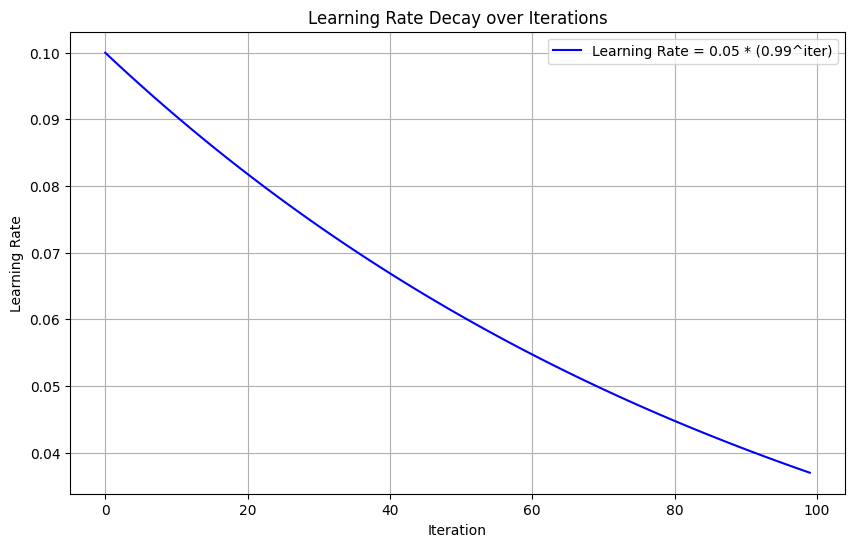

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

iterations = np.arange(0, 100)


learning_rate = 0.1 * (0.99 ** iterations)


plt.figure(figsize=(10, 6))
plt.plot(iterations, learning_rate, label='Learning Rate = 0.05 * (0.99^iter)', color='blue')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Decay over Iterations')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Обучение модели LightGBM с использованием динамического изменения
lgb_model_with_dynamic_lr = lgb.train(
    params,                    # Параметры настройки модели
    lgb_train,                 # Датасет для обучения
    num_boost_round=100,       # Количество итераций (деревьев), которые будут построены
    valid_sets=lgb_eval,      # Датасет для валидации (оценки качества модели на каждом этапе)
    callbacks=[lgb.reset_parameter(
        learning_rate=lambda iter: 0.1 * (0.99 ** iter),
        num_leaves=[40] * 65 + [20] * 35,
        feature_fraction=[0.7] * 50 + [0.5] * 50)]
)

# В данном случае используется callback-функция reset_parameter, которая позволяет динамически изменять параметры модели во время обучения.
# Параметр learning_rate (скорость обучения) изменяется по формуле: 0.1 * (0.99 ** iter), где iter - номер текущей итерации.
# Таким образом, скорость обучения постепенно уменьшается с каждой итерацией, начиная с 0.1 и уменьшаясь на 1% на каждой итерации.


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.205500 -> initscore=-1.352267
[LightGBM] [Info] Start training from score -1.352267


In [ ]:

# # Прогнозирование на тестовом наборе
# y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# # Оценка модели
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print(f'RMSE: {rmse:.4f}')



In [ ]:
# Прогнозирование на обучающей выборке
y_train_pred = lgb_model_with_dynamic_lr.predict(X_train, num_iteration=gbm.best_iteration)
y_train_pred = (y_train_pred > 0.5).astype(int)  # Применение порога для бинарной классификации

# Прогнозирование на тестовой выборке
y_test_pred = lgb_model_with_dynamic_lr.predict(X_test, num_iteration=gbm.best_iteration)
y_test_pred = (y_test_pred > 0.5).astype(int)  # Применение порога для бинарной классификации

# Вычисляем правильность на обучающей выборке
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy on train: {:.3f}".format(train_accuracy))

# Вычисляем правильность на проверочной выборке
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy on test: {:.3f}".format(test_accuracy))

Accuracy on train: 0.902
Accuracy on test: 0.865


In [ ]:
# для регрессии
# Пользовательская функция потерь для sMAPE
def smape(preds, dataset):
    labels = dataset.get_label()
    epsilon = 1e-10  # небольшое значение для предотвращения деления на ноль

    # Вычисляем sMAPE
    diff = np.abs(preds - labels)
    sum_abs = np.abs(preds) + np.abs(labels) + epsilon  # Добавляем epsilon для предотвращения деления на ноль
    smape = diff / sum_abs

    # Градиент
    grad = (preds - labels) / (sum_abs * np.sqrt(np.abs(preds) + np.abs(labels) + epsilon))

    # Гессиан
    hess = 1.0 / (sum_abs * np.sqrt(np.abs(preds) + np.abs(labels) + epsilon))

    return grad, hess

# Пример использования пользовательской функции потерь при обучении модели LightGBM
params = {
    'boosting_type': 'gbdt',
    'objective': smape,  # Используем пользовательскую функцию потерь sMAPE
    'metric': 'mse',  # Метрика оценки может быть любой, здесь оставлена mse для примера
    'num_leaves': 64,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'max_depth': 10,
    'min_data_in_leaf': 5,
    'min_gain_to_split': 0.0,
    'verbose': -1,

}

# Обучение модели с пользовательской функцией потерь
# gbm = lgb.train(
#     params,
#     lgb_train,
#     num_boost_round=100,
#     valid_sets=lgb_eval
# )


In [ ]:
# Параметры настройки модели LightGBM для задачи классификации
params = {
    'boosting_type': 'gbdt',         # Тип бустинга (градиентный бустинг на деревьях решений)
    'objective': 'binary',           # Целевая функция (бинарная классификация)
    'metric': 'binary_logloss',      # Метрика оценки качества модели (логарифмическая потеря для бинарной классификации)
    'min_data_in_leaf': 15,
    'num_leaves': 100,                # Максимальное количество листьев в одном дереве
    'learning_rate': 0.1,             # Скорость обучения
    'feature_fraction': 0.8,          # Доля признаков, используемых при обучении каждого дерева
    'max_depth': -1,                  # Максимальная глубина деревьев
    'seed': 42,                       # Начальное значение для генерации случайных чисел (для воспроизводимости)
    'verbose': -1 ,                    # Уровень детализации выводимых сообщений (отключение вывода)
    'lambda_l2': 11.9,
    'lambda_l1': 11.9,
}
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=50,
                valid_sets=lgb_eval
                )
# Прогнозирование на тестовом наборе
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)


In [ ]:

# Прогнозирование на обучающей выборке
y_train_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_train_pred = (y_train_pred > 0.5).astype(int)  # Применение порога для бинарной классификации

# Прогнозирование на тестовой выборке
y_test_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_test_pred = (y_test_pred > 0.5).astype(int)  # Применение порога для бинарной классификации

# Вычисляем правильность на обучающей выборке
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy on train: {:.3f}".format(train_accuracy))

# Вычисляем правильность на проверочной выборке
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy on test: {:.3f}".format(test_accuracy))

Accuracy on train: 0.870
Accuracy on test: 0.863


In [ ]:
# Выполнение кросс-валидации с использованием встроенного метода LightGBM
# cv_results = lgb.cv(
#     params,
#     lgb_train,
#     num_boost_round=100,
#     nfold=5,
#     metrics='rmse',
#     stratified=False,

# )

cv_results = lgb.cv(
    params,
    lgb_train,
    num_boost_round=100,
    nfold=5,
    metrics='binary_logloss',
    stratified=False,

)

In [ ]:
cv_results.keys()

dict_keys(['valid binary_logloss-mean', 'valid binary_logloss-stdv'])

In [ ]:

# Извлечение результатов
# rmse_scores = cv_results['valid rmse-mean']
# rmse_stdv = cv_results['valid rmse-stdv']

# print(f'RMSE Scores: {rmse_scores}')
# print(f'Mean RMSE: {np.mean(rmse_scores)}')
# print(f'Standard Deviation of RMSE: {np.mean(rmse_stdv)}')

# Извлечение метрик из результатов кросс-валидации
logloss_scores = cv_results['valid binary_logloss-mean']
logloss_stdv = cv_results['valid binary_logloss-stdv']

print(f'Binary Log Loss Scores: {logloss_scores}')
print(f'Mean Binary Log Loss: {np.mean(logloss_scores)}')
print(f'Standard Deviation of Binary Log Loss: {np.mean(logloss_stdv)}')


Binary Log Loss Scores: [0.48466130250882306, 0.4570505611896727, 0.4377164426335466, 0.4231217503374354, 0.4099844159542769, 0.39987809693375653, 0.3939600415574261, 0.38574869467382317, 0.38394369554314844, 0.37798040535080274, 0.3726026553383866, 0.3684435028464326, 0.36508517932796036, 0.3622034471277698, 0.36026636967520204, 0.35831793826085623, 0.35645529263062165, 0.35513447316468094, 0.35446573598603, 0.35337157407494113, 0.35303128057582783, 0.35206996840782007, 0.3518801005516427, 0.3516105171163938, 0.3510010139925874, 0.35079488545990645, 0.35059095883624336, 0.35032648405706984, 0.3503683791501078, 0.3502017126971836, 0.3503723502457147, 0.3504743658566214, 0.3505191915621038, 0.3508938345433576, 0.35111980462633724, 0.3515983421664935, 0.35172830222374796, 0.3519981487048845, 0.352609068155113, 0.3533226606633805, 0.3535681131618718, 0.3536635800344671, 0.3539103761850057, 0.3542512700733045, 0.3546966400881728, 0.355214960585573, 0.3560396562484148, 0.35613300534590486, 

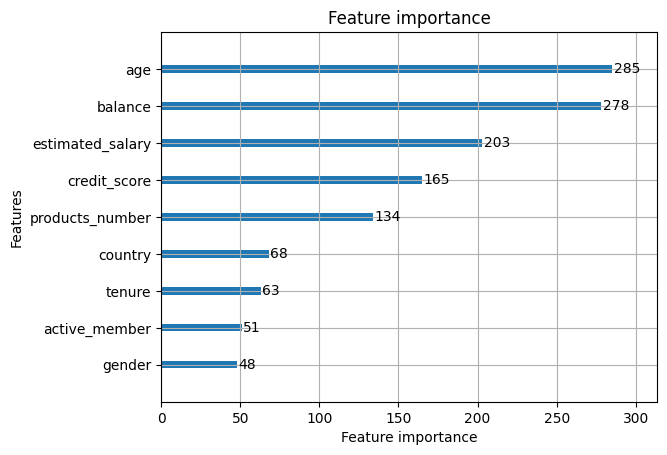

In [ ]:
# строим график важностей, тип важности - количество
# разбиений с использованием данного признака
lgb.plot_importance(booster=gbm, importance_type='split');

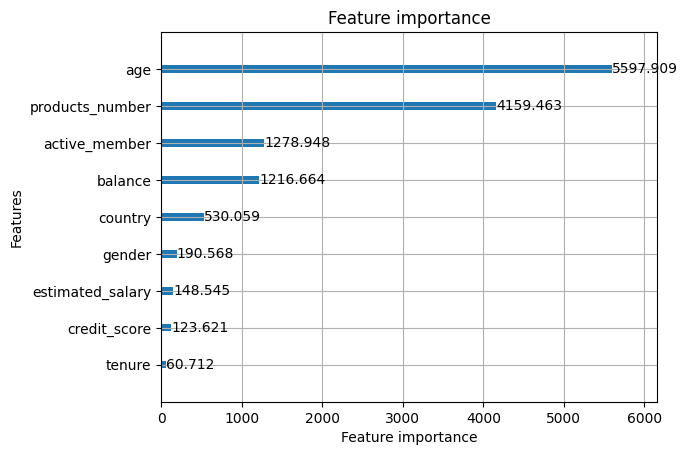

In [ ]:
# строим график важностей, тип важности - выигрыш
lgb.plot_importance(booster=gbm, importance_type='gain');

In [ ]:
# import lightgbm as lgb
# from sklearn.metrics import mean_squared_error

# # создаем экземпляр класса LGBMRegressor
# lgb_model_sklearn = lgb.LGBMRegressor(learning_rate=0.05,
#                                       n_estimators=1200,
#                                       max_depth=4,
#                                       objective='regression',
#                                       random_state=42,
#                                       verbose=-1)

# # строим модель
# lgb_model_sklearn.fit(X_train, y_train)

# # оцениваем модель lightgbm
# train_predictions = lgb_model_sklearn.predict(X_train)
# valid_predictions = lgb_model_sklearn.predict(X_test)

# print("MSE на обучающей выборке: {:.3f}".format(
#     mean_squared_error(y_train, train_predictions)))
# print("MSE на проверочной выборке: {:.3f}".format(
#     mean_squared_error(y_test, valid_predictions)))


MSE на обучающей выборке: 0.068
MSE на проверочной выборке: 0.103


In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, log_loss

# Создаем экземпляр класса LGBMClassifier
lgb_model_sklearn = lgb.LGBMClassifier(
    learning_rate=0.05,
    n_estimators=1200,
    max_depth=4,
    objective='binary',            # Задача бинарной классификации
    random_state=42,
    verbose=-1
)

# Строим модель
lgb_model_sklearn.fit(X_train, y_train)

# Оцениваем модель LightGBM
train_predictions = lgb_model_sklearn.predict(X_train)
valid_predictions = lgb_model_sklearn.predict(X_test)
valid_proba = lgb_model_sklearn.predict_proba(X_test)[:, 1]  # Вероятности положительного класса

print("Accuracy на обучающей выборке: {:.3f}".format(
    accuracy_score(y_train, train_predictions)))
print("Accuracy на проверочной выборке: {:.3f}".format(
    accuracy_score(y_test, valid_predictions)))
print("Log Loss на проверочной выборке: {:.3f}".format(
    log_loss(y_test, valid_proba)))


Accuracy на обучающей выборке: 0.932
Accuracy на проверочной выборке: 0.865
Log Loss на проверочной выборке: 0.346
